In [1]:
from __future__ import absolute_import

#check if there is an evirronment variable called ROOT_PATH
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

# import local_settings
import importlib

from copy import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from types import SimpleNamespace

import matplotlib.pyplot as plt
from models import MLP, OneOverSqr, DualRateModel,SingleRateFlexModel
from dsp_utils import seg_time
from siggen_utils import herzfeld_block
from plt_utils import plot_by_key,plot_segments

from dsp_utils import parse_samples

from runners import Runner



In [2]:
P0=0
Pplus=1
Pminus=-1
Pchannel=np.nan

TfN1 = 100
TfA = 400
TfN2 = 300

TsN=60
TsA=120
TsB=20
TsC=20

# T=300
TaN=150
TaB=120

playlist = {
# 'frogs': [(P0,TfN1),((P0,Pplus),TfA),(P0,TfN2)],
# 'anti_frogs': [(P0,TfN1),(Pplus,TfA),(P0,TfN2)],
# 'frogs_long': [(P0,TfN1),((P0,Pplus),2*TfA),(P0,TfN2)],
# 'anti_frogs_long': [(P0,TfN1),(Pplus,2*TfA),(P0,TfN2)],
# 'savings': 2 * [(P0, TsA), (Pplus, TsA)], #, (Pminus, TsB), (Pchannel, TsC)],
# 'savings': [(P0, TsA), (Pplus, TsA),(P0, 2000),(Pplus, TsA)], #, (Pminus, TsB), (Pchannel, TsC)],
'savings': 2 * [(P0, TsN), (Pplus, TsA), (Pminus, TsB), (Pchannel, TsC)],
'sprecovery': [(P0, 50),
               (Pplus, 120),
               (Pminus, 15),
               (Pchannel, 140)],
'evrecovery': [(P0, 50),
               (Pplus, 120),
               (Pminus, 15),
               (Pchannel, 2),
               (Pplus, 2),
               (Pchannel, 140)],
# 'spOVRrecovery': [(P0, 50),
#                (Pplus, 450),
#                (Pminus, 15),
#                (Pchannel, 140)],
# 'spOVRrecovery_ref': [(P0, 50),
#                (Pplus, 150),
#                (Pminus, 15),
#                (Pchannel, 140)],
# 'lng_recovery': [(P0, 192),
#                (Pplus, 384),
#                (Pminus, 384),
#                (Pchannel, 400)],    
# 'AB0':[(P0, TaN),(Pminus, TaB)],
# 'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
# 'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
# 'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
# 'ANB0':[(P0, TaN),(Pminus, TaB)],
# 'ANB1':[(P0, TaN),(Pplus,13),(P0, TaB),(Pminus, TaB)],
# 'ANB2':[(P0, TaN),(Pplus,41),(P0, TaB),(Pminus, TaB)],
# 'ANB3':[(P0, TaN),(Pplus,112),(P0, TaB),(Pminus, TaB)],
    }

def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
# playlist.update(generate_herzfeld_scenarios(**hrz_params))
        

In [3]:
# frog_playlist = {
# f'frogs{f}': [(P0,TfN1),((P0,Pplus),TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])}

# frog_playlist_a = {
# f'anti_frogs{f}': [(P0,TfN1),(Pplus,TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])} 

# frog_playlist.update(frog_playlist_a)

In [4]:
test_vec= np.stack([np.zeros(200),
                    np.zeros(200),
                    np.zeros(200),
                   np.linspace(2*Pminus,2*Pplus,200)]).T

x_test = test_vec[:,-1]


In [ ]:
cnt =0

results = {}
swarg2s =  [1e-20,5e-4, 3e-4, 1e-4] #[0.05,0.1,0.2,0.5,1,2]
swarg1s = [None] #, 0.3] #[0, 0.2, 0.5]
for i1, swarg1 in enumerate(swarg1s):
    for i2, swarg2 in enumerate(swarg2s):
        lr = swarg2
        # b_high = 0.5
        w= 0.2
        _ = swarg1
        model_construct_args =  dict(n_inputs = 4,
                          n_hidden = 512,
                          n_outs = 1,
                          en_bias = False,
                         b_high=3, first_layer_init='ones',
                        first_layer_weights_trainable = False,
                        out_layer_init='zeros',
                          nl = lambda : OneOverSqr(w=w), skip_gain= 0)
        # define loss |x-y|^p:
        p=4.
        criterion = lambda x,y: torch.abs(x - y) ** p

        # aux_singlerate_model = DualRateModel(0,0,1-1/50,1/200)
        # aux_singlerate_model = SingleRateFlexModel(1-1/50,1/200)
        # aux_singlerate_model = SingleRateFlexModel(1-1/10,1/50)
        aux_singlerate_model = SingleRateFlexModel(1-1/50,1/50,c=0.3,d=0.3)
        # setting = {'criterion':'MSE', 'k':[0,0,0,1], 'learning_rate':lr, 'sigma_noi':0.0, 'tau_u':1,'enable_combo':True,'aux_parallel_model':aux_singlerate_model}
        setting = {'criterion':criterion, 'k':[0,0,0,1], 'learning_rate':lr/w, 'sigma_noi':0.0, 'tau_u':1,'enable_combo':True,'aux_parallel_model':aux_singlerate_model}
        runner = Runner(model_construct_args=model_construct_args,
                        test_vec=test_vec,
                        **setting)
        results[(i1,i2)] = runner.run_multiple(playlist)

running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery
running scenario: savings
running scenario: sprecovery
running scenario: evrecovery


In [23]:
def do_plots(results,playlist,figsize=(18, 6)):
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plot_segments(results['savings'].u_lp,
              t_start=playlist['savings'][0][1],
              n_segments=2,
              t_increment=playlist['savings'][0][1]+playlist['savings'][1][1]+playlist['savings'][2][1]+playlist['savings'][3][1],
              t_segment=playlist['savings'][1][1],             
             )
    plt.ylim([1.5*Pminus,1.5*Pplus])


    plt.subplot(1,3,2)
    plot_by_key(results,
                ['sprecovery','evrecovery'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    plt.ylim([1.5*Pminus,1.5*Pplus])


    plt.subplot(1,3,3)
    
    times = [1, 170, 185]
    colors = ['tab:red','tab:blue','tab:orange','tab:green']
    paradigm = 'sprecovery'
    plt.plot(x_test,x_test,'k:')
    for i,time in enumerate(times):
        u_test = results[paradigm].test_output[time]
        plt.plot(x_test,u_test,colors[i])
        u_t = results[paradigm].u_lp[time]
        plt.plot(u_t, u_test[np.argmin(np.abs(x_test-u_t))],'*',color=colors[i])
    plt.ylim([1.5*Pminus,1.5*Pplus])


    # for t in [170,185]:
    #     plt.plot(results['sprecovery'].test_output[t])
    # plt.show()

In [24]:
def do_plots_full(results,playlist,figsize=(24, 12)):
    plt.figure(figsize=figsize)
    plt.subplot(2,3,1)
    plot_segments(results['savings'].u_lp,
              t_start=playlist['savings'][0][1],
              n_segments=3,
              t_increment=playlist['savings'][0][1]+playlist['savings'][1][1],
              t_segment=playlist['savings'][1][1],             
             )
    plt.subplot(2,3,2)
    plot_by_key(results, ['frogs','anti_frogs'],visu_offsets = [0, 0.0])
    plt.xlabel('epochs')
    plt.ylabel('u(epoch) [au]')
    plt.subplot(2,3,3)
    plot_by_key(results,
                ['sprecovery','evrecovery'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    plt.subplot(2,3,4)
    plot_by_key(results,
                ['spOVRrecovery','spOVRrecovery_ref'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )


    # plt.subplot(2,3,5)
    # plot_by_key(results, ['frogs_long','anti_frogs_long'],visu_offsets = [0, 0.0])
    # plt.xlabel('epochs')
    # plt.ylabel('u(epoch) [au]')

    plt.subplot(2,3,5)
    plot_by_key(results,
                ['AB0','AB1','AB2','AB3'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )
    
    # plt.subplot(2,3,5)
    # plot_by_key(results,
    #             ['ANB0','ANB1','ANB2','ANB3'],
    #             colors=['tab:red','tab:blue','tab:orange','tab:green'],
    #             align_end=True,
    #             visu_offsets=[0]*10,
    #            )
    
    plt.subplot(2,3,6)
    for iz, z in enumerate(hrz_params['z_list']):
        deltas = []
        scenario = f'herzfeld,z={z}'
        this_result = results[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append(this_result.u_lp[pointer-1]-this_result.u_lp[pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')
    plt.legend(loc='upper right')
    plt.xlabel('block #')
    plt.ylabel('adaptation delta channel2-channel1')

In [25]:
def compute_herzfeld_probes(result,paradigm_data,hrz_params):
    deltas = []
    this_result = result
    pointer = 0
    for bb in range(hrz_params['n_blocks']):
        block_length = paradigm_data[bb][-1]
        pointer += block_length
        deltas.append(this_result.u_lp[pointer-1]-this_result.u_lp[pointer-3]) 
    return deltas           


In [26]:
def plot_stimulus(paradigm_stimulus):
    plt.figure()
    
    for i,stimulus in enumerate(paradigm_stimulus):
        plt.plot(stimulus,label=f'stimulus {i}')
    plt.legend(loc='upper right')
    plt.xlabel('time')
    plt.ylabel('stimulus [au]')

In [27]:
swarg2s

[1e-20, 0.0005, 0.0003, 0.0001]

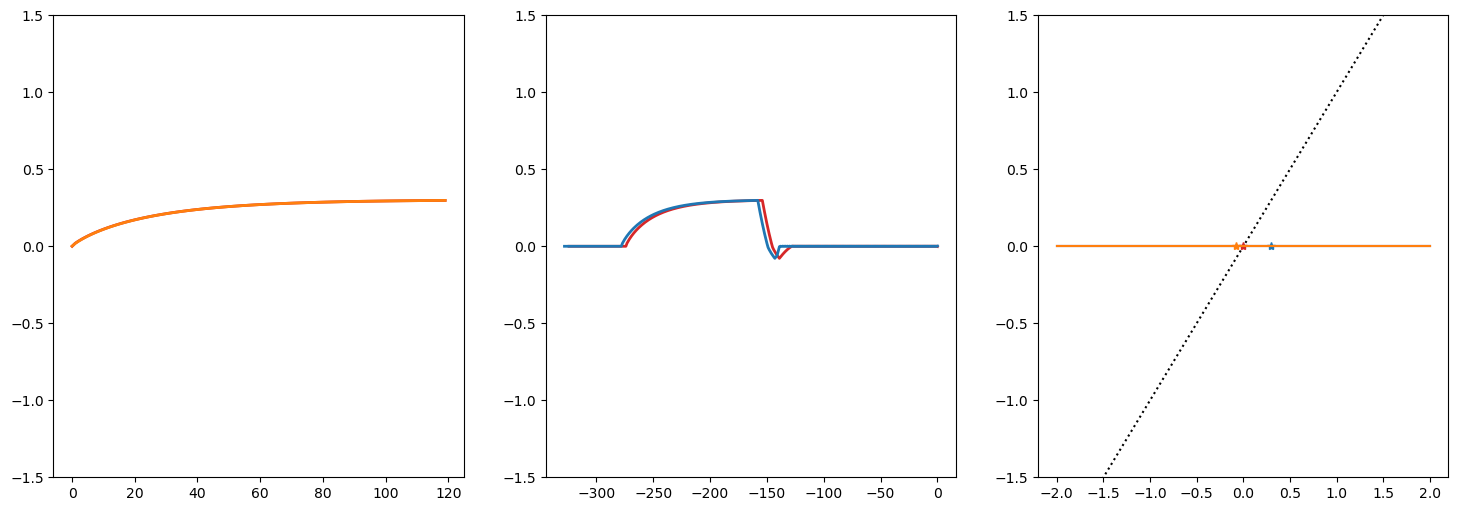

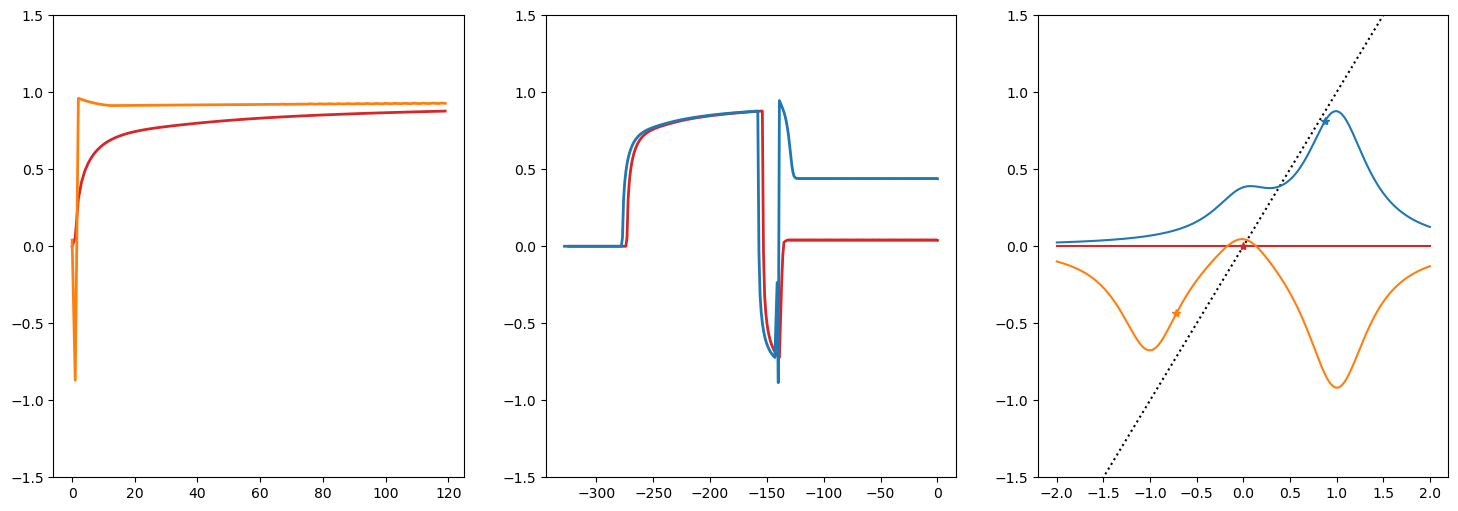

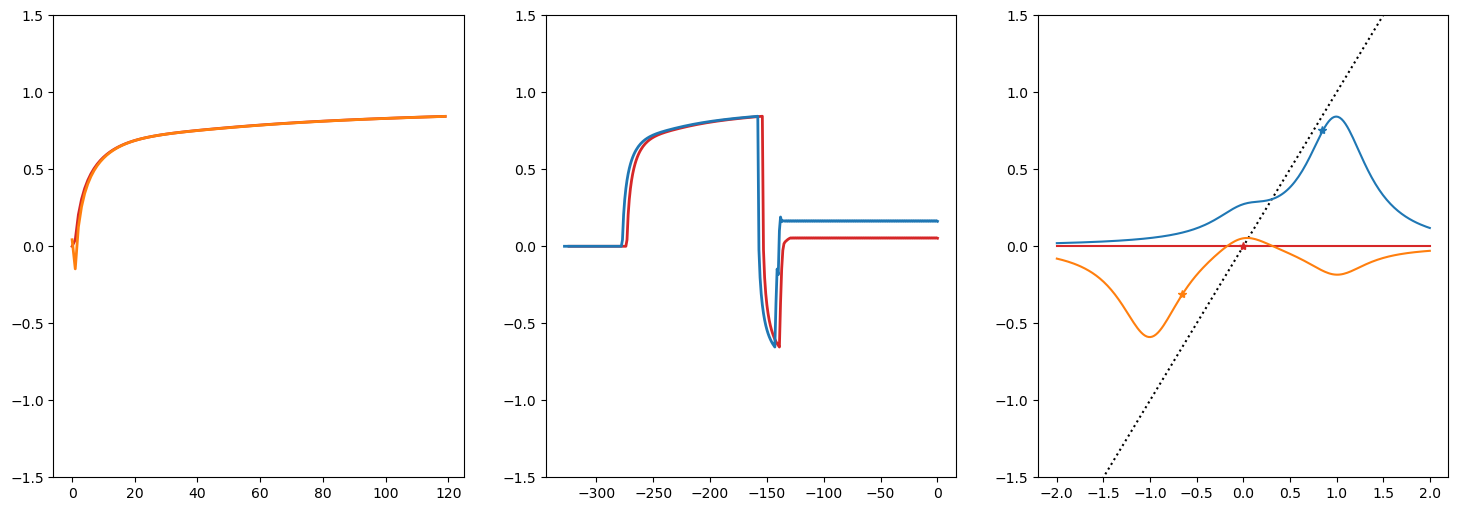

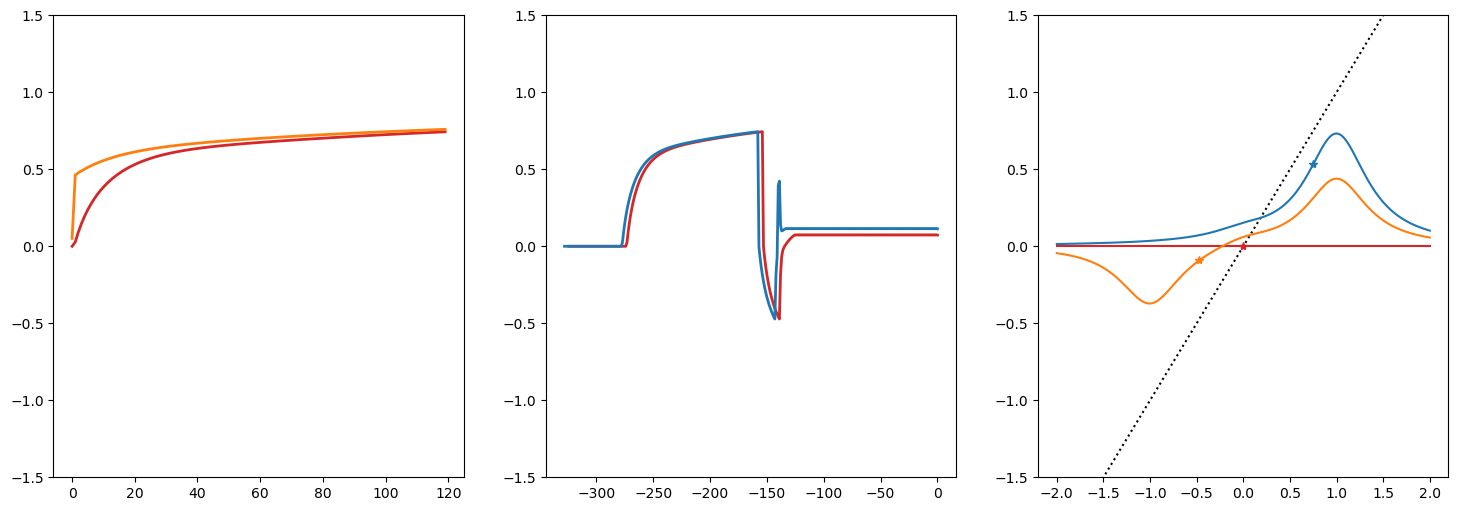

In [30]:
for i2,swarg2 in enumerate(swarg2s):
    for i1,swarg1 in enumerate(swarg1s):
        item = (i1,i2)
        do_plots(results[item],playlist)


KeyError: 'frogs'

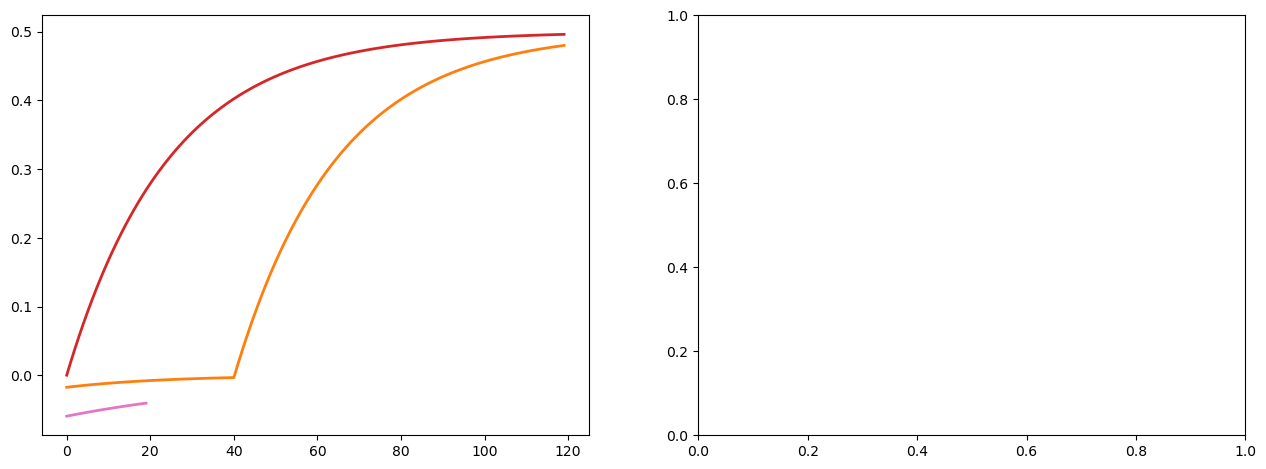

In [12]:
for i2,swarg2 in enumerate(swarg2s):
    for i1,swarg1 in enumerate(swarg1s):
        item = (i1,i2)
        do_plots_full(results[item],playlist)


In [ ]:
#generating plots according to the plot_spec
def do_plots_spec(results,playlist,plot_spec, default_plot_spec=None):
#prepare figure; number of lines is len(plot_spec)
#each line will have 3 subplots: stimulus, model output, xtest plot
#if paradigm is a list then all paradigms from the list are plotted.
#depending on whether paradigm_plot_opts is 'stacked' or 'separate' the plots are either stacked or separate within the subplot axis
#depending on whether model_plot_opts is 'stacked' or 'together' the plots are either stacked or together within the subplot axis
#xtest plots are taken at times that correspond to end of segment of the playlist that is specified in (<paradigm>,<segment>) in in_out_plot_content
    n_lines = len(plot_spec)
    plt.figure(figsize=(9, 3*n_lines))
    for i, spec in enumerate(plot_spec):
        if default_plot_spec is not None:
            spec = {**default_plot_spec, **spec}
        plt.subplot(n_lines,3,3*i+1)
        paradigm = spec['paradigm']
        paradigm_plot_opts = spec['paradigm_plot_opts']
        model_plot_opts = spec['model_plot_opts']
        in_out_plot_content = spec['in_out_plot_content']
        if type(paradigm) is not list:
            paradigms = [paradigm]
        else:
            paradigms = paradigm

        for paradigm in paradigms:
            y_data = parse_samples(playlist[paradigm])
            if spec['paradigm_plot_interval'] is not None:
                y_data = y_data[spec['paradigm_plot_interval'][0]:spec['paradigm_plot_interval'][1]]
            plt.plot(y_data)#,paradigm_plot_opts)
            

        plt.subplot(n_lines,3,3*i+2)
        for paradigm in paradigms:
            if spec['plot_blocks']:
                y_data = compute_herzfeld_probes(results[paradigm],playlist[paradigm],hrz_params)
            #     plt.plot(deltas,label=paradigm)
            # plt.legend()
            else:
                # plot_by_key(results,paradigms,colors=['tab:red','tab:blue','tab:orange','tab:green'],visu_offsets=[0]*10)#,model_plot_opts)
                y_data = results[paradigm].u_lp
            plt.plot(y_data)


        plt.subplot(n_lines,3,3*i+3)
        
        for paradigm, segment in in_out_plot_content:
            #compute time at the end of the segment
            pointer = 0
            for bb in range(segment+1):
                pointer += playlist[paradigm][bb][-1]
            print(paradigm,segment,i,pointer)
            
            # colors = ['tab:red','tab:blue','tab:orange','tab:green']
            # for i,time in enumerate(times):
            u_test = results[paradigm].test_output[pointer-1]
            if spec['in_out_plot_type'] == 'xy':
                ydata = u_test
                fpline = x_test
            elif spec['in_out_plot_type'] == 'xdeltay':
                ydata = u_test.reshape(-1)-x_test.reshape(-1)
                fpline = 0*x_test
            plt.plot(x_test,ydata)

            plt.plot(x_test,fpline,'k:')

            # plt.plot(x_test,u_test)#,colors[i])

        # plt.xlim([0.5*Pminus,1.5*Pplus])
        # plt.ylim([0.5*Pminus,1.5*Pplus])





In [ ]:
plot_spec =[dict(paradigm='savings', paradigm_plot_opts=None, model_plot_opts=None, 
                 in_out_plot_content=[('savings',0),('savings',1),('savings',2)]),
            dict(paradigm=['frogs_long','anti_frogs_long'], paradigm_plot_opts='stacked', model_plot_opts='stacked',
                 in_out_plot_content=[('frogs_long',1),('anti_frogs_long',1)]),
            dict(paradigm=['sprecovery','evrecovery'], paradigm_plot_opts='separate', model_plot_opts='stacked',
                 in_out_plot_content=[('sprecovery',1),('sprecovery',2)],in_out_plot_type='xdeltay'),
            dict(paradigm=['spOVRrecovery','spOVRrecovery_ref'], paradigm_plot_opts='separate', model_plot_opts='stacked',
                 in_out_plot_content=[('spOVRrecovery',1),('spOVRrecovery_ref',1)],in_out_plot_type='xdeltay'),
            dict(paradigm=[f'herzfeld,z={z}' for z in hrz_params['z_list']], paradigm_plot_opts='separate', model_plot_opts='stacked',
            in_out_plot_content=[], plot_blocks=True, paradigm_plot_interval=[0,70]),]

default_plot_spec = dict(in_out_plot_content=[], plot_blocks=False, in_out_plot_type='xy',paradigm_plot_interval=None)

savings 0 0 60
savings 1 0 180
savings 2 0 200
frogs_long 1 1 900
anti_frogs_long 1 1 900
sprecovery 1 2 170
sprecovery 2 2 185
spOVRrecovery 1 3 500
spOVRrecovery_ref 1 3 200


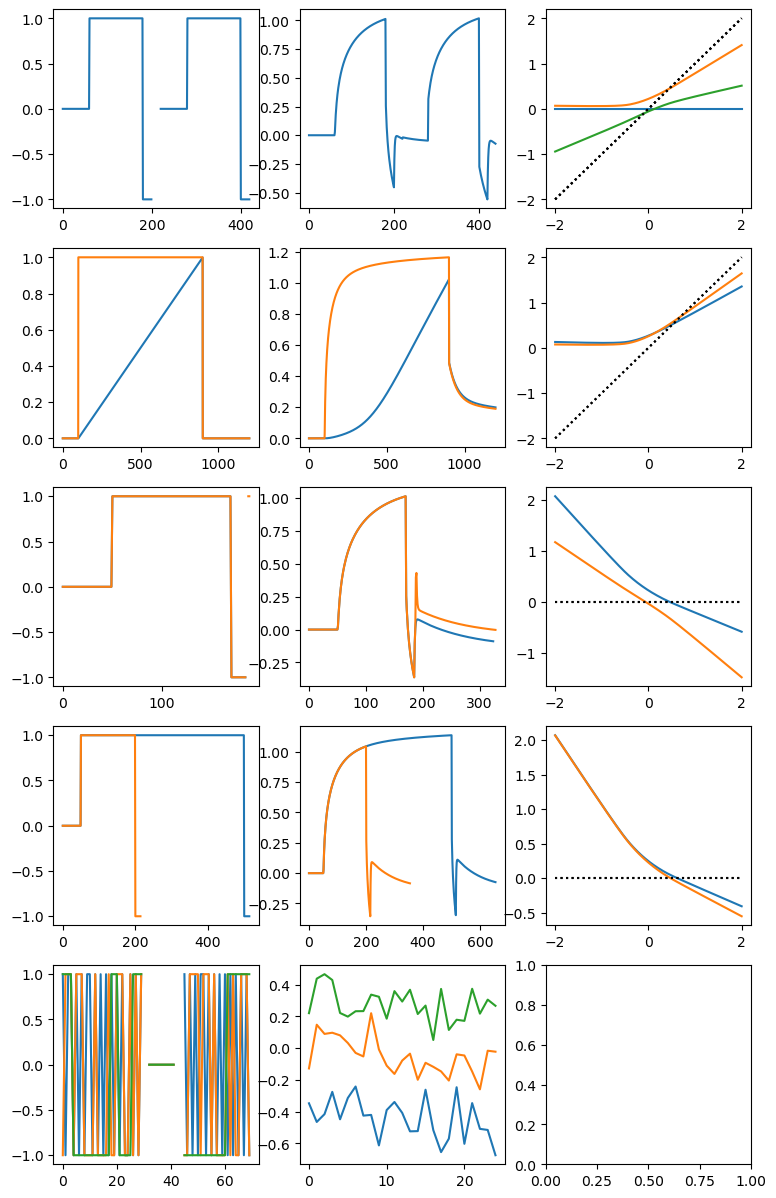

In [ ]:
do_plots_spec(results[(0,0)],playlist,plot_spec,default_plot_spec=default_plot_spec)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def extract_plot_data(results, playlist, plot_spec, default_plot_spec=None):
    """
    Extracts x,y data pairs from simulation results according to plot_spec.
    
    Returns a list (one element per spec/row) where each element is a dict with keys:
      - "stimulus": a list of dicts with keys "x", "y", "label", and optionally "plot_opts"
      - "model_output": similar structure as stimulus
      - "xtest": a list of dicts with keys "x", "y", "label", and optionally "line_opts"
    """
    plot_data = []
    for spec in plot_spec:
        # Merge with default spec if provided
        if default_plot_spec is not None:
            spec = {**default_plot_spec, **spec}
            
        row_data = {"stimulus": [], "model_output": [], "xtest": []}
        
        # Ensure paradigms is a list.
        paradigms = spec['paradigm'] if isinstance(spec['paradigm'], list) else [spec['paradigm']]
        
        # --- Stimulus data ---
        for paradigm in paradigms:
            y_data = parse_samples(playlist[paradigm])
            if spec.get('paradigm_plot_interval') is not None:
                start, end = spec['paradigm_plot_interval']
                y_data = y_data[start:end]
            # Add x-data as np.arange
            x_data = np.arange(len(y_data))
            row_data["stimulus"].append({
                "x": x_data,
                "y": y_data,
                "label": paradigm,
                "plot_opts": spec.get('paradigm_plot_opts') or {}
            })
        
        # --- Model output data ---
        for paradigm in paradigms:
            if spec.get('plot_blocks'):
                # hrz_params is assumed to be defined globally
                y_data = compute_herzfeld_probes(results[paradigm], playlist[paradigm], hrz_params)
            else:
                y_data = results[paradigm].u_lp
            x_data = np.arange(len(y_data))
            row_data["model_output"].append({
                "x": x_data,
                "y": y_data,
                "label": paradigm,
                "plot_opts": spec.get('model_plot_opts') or {}
            })
        
        # --- xtest data ---
        for paradigm, segment in spec.get('in_out_plot_content', []):
            pointer = 0
            for bb in range(segment + 1):
                pointer += playlist[paradigm][bb][-1]
            u_test = results[paradigm].test_output[pointer - 1]
            if spec.get('in_out_plot_type') == 'xy':
                y_data = u_test
                fpline = x_test  # Assumes x_test is defined globally
            elif spec.get('in_out_plot_type') == 'xdeltay':
                y_data = u_test.reshape(-1) - x_test.reshape(-1)
                fpline = np.zeros_like(x_test)
            else:
                y_data = u_test
                fpline = x_test
            x_data = x_test
            row_data["xtest"].append({
                "x": x_data,
                "y": y_data,
                "label": f"xtest {paradigm} seg {segment}",
                "line_opts": {}
            })
            row_data["xtest"].append({
                "x": x_data,
                "y": fpline,
                "label": f"fpline {paradigm} seg {segment}",
                "line_opts": {"linestyle": ":", "color": "k"}
            })
        
        plot_data.append(row_data)
    
    return plot_data



def plot_data_pairs(plot_data):
    """
    Plots the data pairs created by extract_plot_data.
    Creates a figure with three subplots per row corresponding to stimulus, model output, and xtest data.
    """
    n_lines = len(plot_data)
    plt.figure(figsize=(9, 3 * n_lines))
    
    for i, row_data in enumerate(plot_data):
        # --- Plot stimulus data ---
        ax1 = plt.subplot(n_lines, 3, 3 * i + 1)
        for series in row_data["stimulus"]:
            opts = series.get("plot_opts") or {}
            # Ensure opts is a dict
            if not isinstance(opts, dict):
                opts = {}
            plt.plot(series["x"], series["y"], label=series.get("label"), **opts)
        plt.title("Stimulus")
        plt.legend()
        
        # --- Plot model output data ---
        ax2 = plt.subplot(n_lines, 3, 3 * i + 2)
        for series in row_data["model_output"]:
            opts = series.get("plot_opts") or {}
            if not isinstance(opts, dict):
                opts = {}
            plt.plot(series["x"], series["y"], label=series.get("label"), **opts)
        plt.title("Model Output")
        plt.legend()
        
        # --- Plot xtest data ---
        ax3 = plt.subplot(n_lines, 3, 3 * i + 3)
        for series in row_data["xtest"]:
            opts = series.get("line_opts") or {}
            if not isinstance(opts, dict):
                opts = {}
            plt.plot(series["x"], series["y"], label=series.get("label"), **opts)
        plt.title("XTest")
        plt.legend()
    
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_97159/3595392735.py:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


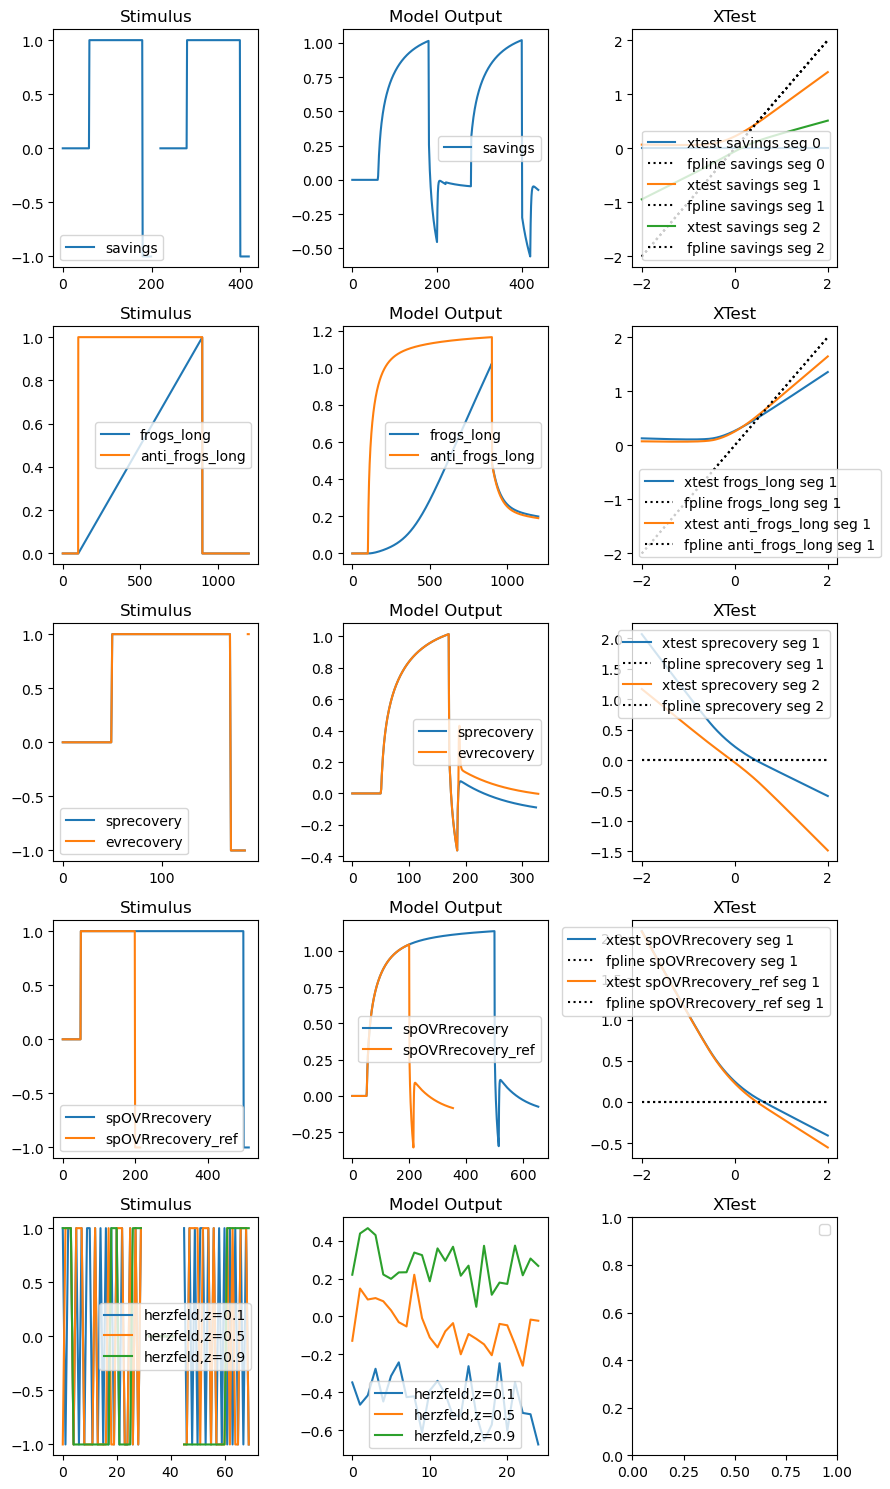

In [ ]:
# First, extract the data
plot_data = extract_plot_data(results[(0,0)],playlist,plot_spec,default_plot_spec=default_plot_spec)

# Then, plot the data
plot_data_pairs(plot_data)

In [ ]:
!pwd

/homes/ar2342
